###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.

# Spreading out

Welcome to the fifth, and last, notebook of Module 4 "_Spreading out: diffusion problems,"_ of our fabulous course **"Practical Numerical Methods with Python."**

In this course module, we have learned about explicit and implicit methods for parabolic equations in 1 and 2 dimensions. So far, all schemes have been first-order in time and second-order in space. _Can we do any better?_ We certainly can: this notebook presents the Crank-Nicolson scheme, which is a second-order method in both time and space! We will continue to use the heat equation to guide the discussion, as we've done throughout this module. 

## Crank-Nicolson scheme

The [Crank Nicolson scheme](http://en.wikipedia.org/wiki/Crank–Nicolson_method) is a popular second-order, implicit method used with parabolic PDEs in particular. It was developed by John Crank and [Phyllis Nicolson](http://en.wikipedia.org/wiki/Phyllis_Nicolson). The main idea is to take the average between the solutions at $t^n$ and $t^{n+1}$ in the evaluation of the spatial derivative. Why bother doing that? Because the time derivative will then be discretized with a centered scheme, giving second-order accuracy!

Remember the 1D heat equation from the [first notebook](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_01_Heat_Equation_1D_Explicit.ipynb)? Just to refresh your memory, here it is:

$$
\begin{equation}
    \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2}.
\end{equation}
$$

In this case, the Crank-Nicolson scheme leads to the following discretized equation:

$$
\begin{equation}
    \begin{split}
        & \frac{T^{n+1}_i - T^n_i}{\Delta t} = \\
        & \quad \alpha \cdot \frac{1}{2} \left( \frac{T^{n+1}_{i+1} - 2 T^{n+1}_i + T^{n+1}_{i-1}}{\Delta x^2} + \frac{T^n_{i+1} - 2 T^n_i + T^n_{i-1}}{\Delta x^2} \right) \\
    \end{split}
\end{equation}
$$

Notice how the both time indices $n$ and $n+1$ appear on the right-hand side. You know we'll have to rearrange this equation, right? Now look at the stencil and notice that we are using more information than before in the update.

![stencil-cranknicolson](./figures/stencil-cranknicolson.png)
#### Figure 2. Stencil of the Crank-Nicolson scheme.

Rearranging terms so that everything that we don't know is on the left side and what we do know on the right side, we get

$$
\begin{equation}
    \begin{split}
        & -T^{n+1}_{i-1} + 2 \left( \frac{\Delta x^2}{\alpha \Delta t} + 1 \right) T^{n+1}_i - T^{n+1}_{i+1} \\
        & \qquad = T^{n}_{i-1} + 2 \left( \frac{\Delta x^2}{\alpha \Delta t} - 1 \right) T^{n}_i + T^{n}_{i+1} \\
    \end{split}
\end{equation}
$$

Again, we are left with a linear system of equations. Check out the left side of that equation: it looks a lot like the matrix from [notebook 2](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb), doesn't it? Apart from the slight modification in the $T_i^{n+1}$ term, the left side of the equation is pretty much the same. What about the right-hand side? Sure, it looks quite different, but that is not a problem, we know all those terms!

Things don't change much for boundary conditions, either. We've seen all the cases already. Say $T_0^{n+1}$ is a Dirichlet boundary. Then the equation for $i=1$ becomes

$$
\begin{equation}
    \begin{split}
         & 2 \left( \frac{\Delta x^2}{\alpha \Delta t} + 1 \right) T^{n+1}_1 - T^{n+1}_{2} \\ 
         & \qquad = T^{n}_{0} + 2 \left( \frac{\Delta x^2}{\alpha \Delta t} - 1 \right) T^{n}_1 + T^{n}_{2} + T^{n+1}_{0} \\
    \end{split}
\end{equation}
$$

And if we have a Neumann boundary $\left(\left.\frac{\partial T}{\partial x}\right|_{x=L} = q\right)$ at $T_{n_x-1}^{n+1}$? We know this stuff, right? For $i=n_x-2$ we get

$$
\begin{equation}
    \begin{split}
        & -T^{n+1}_{n_x-3} + \left( 2 \frac{\Delta x^2}{\alpha \Delta t} + 1 \right) T^{n+1}_{n_x-2} \\
        & \qquad = T^{n}_{n_x-3} + 2 \left( \frac{\Delta x^2}{\alpha \Delta t} - 1 \right) T^{n}_{n_x-2} + T^{n}_{n_x-1} + q\Delta x \\
    \end{split}
\end{equation}
$$

The code will look a lot like the implicit method from the [second notebook](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb). Only some terms of the matrix and right-hand-side vector will be different, which changes some of our custom functions.

### The linear system

Just like in [notebook 2](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb), we need to solve a linear system on every time step of the form:

$$
[A][T^{n+1}_\text{int}] = [b]+[b]_{b.c.}
$$

The coefficient matrix is very similar to the previous case, but the right-hand side changes a lot:

$$
\begin{align}
    \left[
        \begin{array}{cccccc}
             2 \left( \frac{1}{\sigma} + 1 \right) & -1 & 0 & \cdots & & 0 \\
             -1 & 2 \left( \frac{1}{\sigma} + 1\right) & -1 & 0 & \cdots & 0 \\
             0 & & \ddots & & & \vdots \\
             \vdots & & & & 2 \left( \frac{1}{\sigma} + 1\right) & \\
             0 & \cdots & & & -1 & \left( 2 \frac{1}{\sigma} + 1\right) \\
        \end{array}
    \right] \cdot 
    \left[
        \begin{array}{c} 
             T_1^{n+1} \\
             T_2^{n+1} \\
             \vdots \\
             \\
             T_{N-2}^{n+1} \\
        \end{array}
    \right] =
    \left[
        \begin{array}{c}
            T_0^n + 2 \left( \frac{1}{\sigma} - 1 \right) T_1^n + T_2^n \\
            T_1^n + 2 \left( \frac{1}{\sigma} - 1 \right) T_2^n + T_3^n \\
            \vdots \\
            \\
            T_{n_x-3}^n + 2 \left( \frac{1}{\sigma} - 1 \right) T_{n_x-2}^n + T_{n_x-1}^n \\
        \end{array}
    \right] +
    \begin{bmatrix}
        T_0^{n+1} \\
        0\\
        \vdots \\
        0 \\
        q \Delta x \\
    \end{bmatrix}
\end{align}
$$

Let's write a function that will create the coefficient matrix and right-hand-side vectors for the heat conduction problem from [notebook 2](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb): with Dirichlet boundary at $x=0$ and zero-flux boundary $(q=0)$ at $x=L$.

In [1]:
import numpy
from scipy import linalg

In [2]:
def lhs_operator(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use Crank-Nicolson method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = numpy.diag(2.0 * (1.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 2.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [3]:
def rhs_vector(T, sigma, qdx):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    on the left side and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    b = T[:-2] + 2.0 * (1.0 / sigma - 1.0) * T[1:-1] + T[2:]
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b

We will solve the linear system at every time step. Let's define a function to step in time:

In [4]:
def crank_nicolson(T0, nt, dt, dx, alpha, q):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Crank-Nicolson method in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
    return T

And we are good to go! First, let's setup our initial conditions, and the matrix

In [5]:
# Set parameters.
L = 1.0  # length of the rod
nx = 21  # number of points on the rod
dx = L / (nx - 1)  # grid spacing
alpha = 1.22e-3  # thermal diffusivity of the rod
q = 0.0  # temperature gradient at the extremity

# Define the locations on the rod.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial temperature distribution.
T0 = numpy.zeros(nx)
T0[0] = 100.0

Check the matrix...

In [6]:
A = lhs_operator(nx - 1, 0.5)
print(A)

[[ 6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [-1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  6. -1.  0.  0.  0.

Looks okay! Now, step in time

In [7]:
# Set the time-step size based on CFL limit.
sigma = 0.5
dt = sigma * dx**2 / alpha  # time-step size
nt = 10  # number of time steps to compute

# Compute the temperature distribution.
T = crank_nicolson(T0, nt, dt, dx, alpha, q)

And plot,

In [8]:
from matplotlib import pyplot
%matplotlib inline

In [9]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

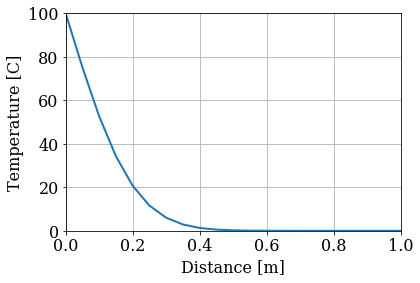

In [10]:
# Plot the temperature along the rod.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

Works nicely. But wait! This method has elements of explicit and implicit discretizations. Is it *conditionally stable* like forward Euler, or *unconditionally stable* like backward Euler? Try out different values of `sigma`. You'll see Crank-Nicolson is an *unconditionally stable scheme* for the diffusion equation!

## Accuracy & convergence

Using some techniques you might have learned in your PDE class, such as separation of variables, you can get a closed expression for the rod problem. It looks like this:

$$
\begin{eqnarray}
T(x,t) = & \nonumber \\
100 - \sum_{n=1}^{\infty} & \frac{400}{(2n-1)\pi}\sin\left(\frac{(2n-1)\pi}{2L}x\right) \exp\left[-\alpha\left(\frac{(2n-1)\pi}{2L}\right)^2t\right]
\end{eqnarray}
$$

Unfortunately, the analytical solution is a bit messy, but at least it gives a good approximation if we evaluate it for large $n$. Let's define a function that will calculate this for us:

In [11]:
def analytical_temperature(x, t, alpha, L, N):
    """
    Computes and returns a truncated approximation
    of the exact temperature distribution along the rod.
    
    Parameters
    ----------
    x : numpy.ndarray
        Locations at which to calculate the temperature
        as a 1D array of floats.
    t : float
        Time.
    alpha : float
        Thermal diffusivity of the rod.
    L : float
        Length of the rod.
    N : integer
        Number of terms to use in the expansion.
    
    Returns
    -------
    T : numpy.ndarray
        The truncated analytical temperature distribution
        as a 1D array of floats.
    """
    T = 100.0 * numpy.ones_like(x)
    for n in range(1, N + 1):
        k = (2 * n - 1) * numpy.pi / (2.0 * L)
        T -= (400.0 / (2.0 * L * k) *
              numpy.sin(k * x) * numpy.exp(- alpha * k**2 * t))
    return T

And let's see how that expression looks for the time where we left the numerical solution

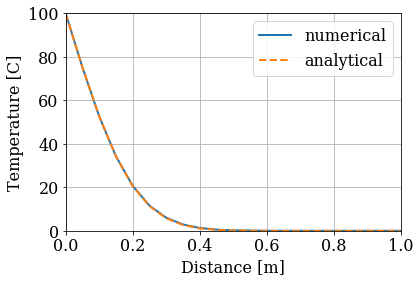

In [12]:
# Compute the analytical temperature distribution.
T_exact = analytical_temperature(x, nt * dt, alpha, L, 100)

# Plot the numerical and analytical temperatures.
pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
pyplot.plot(x, T, label='numerical',
            color='C0', linestyle='-', linewidth=2)
pyplot.plot(x, T_exact, label='analytical',
            color='C1', linestyle='--', linewidth=2)
pyplot.legend()
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [13]:
T1 = analytical_temperature(x, 0.2, alpha, L, 100)
T2 = analytical_temperature(x, 0.2, alpha, L, 200)
numpy.sqrt(numpy.sum((T1 - T2)**2) / numpy.sum(T2**2))

6.927917118260093e-13

That looks like it should. We'll now use this result to study the convergence of the Crank-Nicolson scheme.

### Time convergence

We said this method was second-order accurate in time, remember? That's in theory, but we should test that the numerical solution indeed behaves like the theory says.

Leaving $\Delta x$ constant, we'll run the code for different values of $\Delta t$ and compare the result at the same physical time, say $t=n_t\cdot\Delta t=10$, with the analytical expression above.

The initial condition of the rod problem has a very sharp gradient: it suddenly jumps from $0{\rm C}$ to $100{\rm C}$ at the boundary. To resolve that gradient to the point that it doesn't affect time convergence, we would need a very fine mesh, and computations would be very slow. To avoid this issue, we will start from $t=1$ rather than starting from $t=0$.

First, let's define a function that will compute the $L_2$-norm of the error:

In [14]:
def l2_error(T, T_exact):
    """
    Computes and returns the relative L2-norm
    of the difference between the numerical solution
    and the exact solution.
    
    Parameters
    ----------
    T : numpy.ndarray
        The numerical solution as an array of floats.
    T_exact : numpy.ndarray
        The exact solution as an array of floats.
    
    Returns
    -------
    error : float
        The relative L2-norm of the difference.
    """
    error = numpy.sqrt(numpy.sum((T - T_exact)**2) /
                       numpy.sum(T_exact**2))
    return error

For fun, let's compare the Crank-Nicolson scheme with the implicit (a.k.a., backward) Euler scheme. We'll borrow some functions from [notebook 2](https://nbviewer.jupyter.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/04_spreadout/04_02_Heat_Equation_1D_Implicit.ipynb) to do this.

In [15]:
def lhs_operator_btcs(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use backward Euler method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [16]:
def rhs_vector_btcs(T, sigma, qdx):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    on the left side and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b

In [17]:
def btcs_implicit(T0, nt, dt, dx, alpha, q):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution
        as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator_btcs(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector_btcs(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
    return T

Now, let's do the runs!

In [18]:
# Update parameters.
nx = 1001  # number of points on the rod
dx = L / (nx - 1)  # grid spacing

# Define the locations on the rod.
x = numpy.linspace(0.0, L, num=nx)

# Create a list with the time-step sizes to use.
dt_values = [1.0, 0.5, 0.25, 0.125]

# Create empty lists to hold the errors for both schemes.
errors = []
errors_btcs = []

# Compute the initial temperature distribution at t=1.0.
t0 = 1.0
T0 = analytical_temperature(x, t0, alpha, L, 100)

# Compute the final analytical temperature at t=10.0.
t = 10.0
T_exact = analytical_temperature(x, t, alpha, L, 100)

# Compute the numerical solutions and errors.
for dt in dt_values:
    nt = int((t - t0) / dt)  # number of time steps
    # Compute the solution using Crank-Nicolson scheme.
    T = crank_nicolson(T0, nt, dt, dx, alpha, q)
    # Compute and record the L2-norm of the error.
    errors.append(l2_error(T, T_exact))
    # Compute the solution using implicit BTCS scheme.
    T = btcs_implicit(T0, nt, dt, dx, alpha, q)
    # Compute and record the L2-norm of the error.
    errors_btcs.append(l2_error(T, T_exact))

And plot,

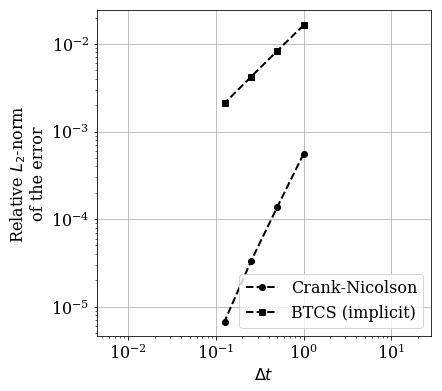

In [19]:
# Plot the error versus the time-step size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.grid()
pyplot.xlabel(r'$\Delta t$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
pyplot.loglog(dt_values, errors, label='Crank-Nicolson',
              color='black', linestyle='--', linewidth=2, marker='o')
pyplot.loglog(dt_values, errors_btcs, label='BTCS (implicit)',
              color='black', linestyle='--', linewidth=2, marker='s')
pyplot.legend()
pyplot.axis('equal');

In [20]:
errors

[0.0005562525604218684,
 0.0001374575644793469,
 3.285170428405964e-05,
 6.771647468538648e-06]

See how the error drops four times when the time step is halved? This method is second order in time!

Clearly, Crank-Nicolson (circles) converges faster than backward Euler (squares)! Not only that, but also the error curve is shifted down: Crank-Nicolson is more accurate.

If you look closely, you'll realize that the error in Crank-Nicolson decays about twice as fast than backward Euler: it's a second versus first order method!

### Spatial convergence

To study spatial convergence, we will run the code for meshes with 21, 41, 81 and 161 points, and compare them at the same non-dimensional time, say $t=20$. 

Let's start by defining a function that will do everything for us

In [21]:
# Set parameters.
dt = 0.1  # time-step size
t = 20.0  # final time
nt = int(t / dt)  # number of time steps to compute

# Create a list with the grid-spacing sizes to use.
nx_values = [11, 21, 41, 81, 161]

# Create an empty list to store the errors.
errors = []

# Compute the numerical solutions and errors.
for nx in nx_values:
    dx = L / (nx - 1)  # grid spacing
    x = numpy.linspace(0.0, L, num=nx)  # grid points
    # Set the initial conditions for the grid.
    T0 = numpy.zeros(nx)
    T0[0] = 100.0
    # Compute the solution using Crank-Nicolson scheme.
    T = crank_nicolson(T0, nt, dt, dx, alpha, q)
    # Compute the analytical solution.
    T_exact = analytical_temperature(x, t, alpha, L, 100)
    # Compute and record the L2-norm of the error.
    errors.append(l2_error(T, T_exact))

And plot!

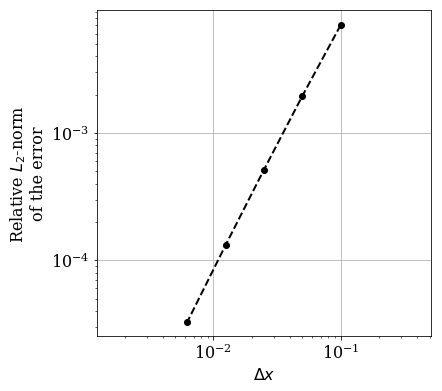

In [22]:
# Plot the error versus the grid-spacing size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.grid()
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
dx_values = L / (numpy.array(nx_values) - 1)
pyplot.loglog(dx_values, errors,
              color='black', linestyle='--', linewidth=2, marker='o')
pyplot.axis('equal');

That looks good! See how for each quadrant we go right, the error drops two quadrants going down (and even a bit better!).

##### Dig deeper

Let's re-do the spatial convergence, but comparing at a much later time, say $t=1000$.

In [23]:
# Set parameters.
dt = 0.1  # time-step size
t = 1000.0  # final time
nt = int(t / dt)  # number of time steps to compute

# Create a list with the grid-spacing sizes to use.
nx_values = [11, 21, 41, 81, 161]

# Create an empty list to store the errors.
errors = []

# Compute the numerical solutions and errors.
for nx in nx_values:
    dx = L / (nx - 1)  # grid spacing
    x = numpy.linspace(0.0, L, num=nx)  # grid points
    # Set the initial conditions for the grid.
    T0 = numpy.zeros(nx)
    T0[0] = 100.0
    # Compute the solution using Crank-Nicolson scheme.
    T = crank_nicolson(T0, nt, dt, dx, alpha, q)
    # Compute the analytical solution.
    T_exact = analytical_temperature(x, t, alpha, L, 100)
    # Compute and record the L2-norm of the error.
    errors.append(l2_error(T, T_exact))

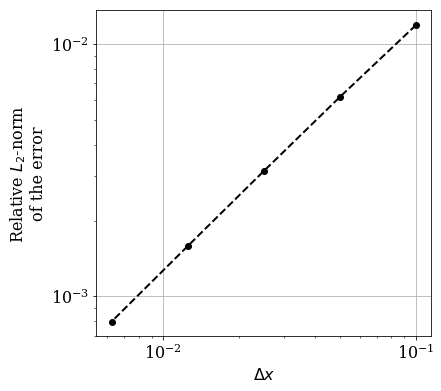

In [24]:
# Plot the error versus the grid-spacing size.
pyplot.figure(figsize=(6.0, 6.0))
pyplot.grid()
pyplot.xlabel(r'$\Delta x$')
pyplot.ylabel('Relative $L_2$-norm\nof the error')
dx_values = L / (numpy.array(nx_values) - 1)
pyplot.loglog(dx_values, errors,
              color='black', linestyle='--', linewidth=2, marker='o')
pyplot.axis('equal');

In [25]:
errors

[0.011922719076357474,
 0.006181593859790544,
 0.003142664307189285,
 0.0015838621626866334,
 0.0007950070915380142]

Wait, convergence is not that great now! It's not as good as second order, but not as bad as first order. *What is going on?*

Remember our implementation of the boundary conditions? We used

$$
\begin{equation}
\frac{T^{n}_{N-1} - T^{n}_{N-2}}{\Delta x} = q
\end{equation}
$$

Well, that is a **first-order** approximation! 

But, why doesn't this affect our solution at an earlier time? Initially, temperature on the right side of the rod is zero and the gradient is very small in that region; at that point in time, errors there were negligible. Once temperature starts picking up, we start having problems.

**Boundary conditions can affect the convergence and accuracy of your solution!**

---
###### The cell below loads the style of the notebook

In [26]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, 'r').read())